# No-Transaction Band Network

In [ ]:
!curl --silent https://raw.githubusercontent.com/pfnet-research/NoTransactionBandNetwork/main/utils.py > utils.py

In [ ]:
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch
import torch.nn.functional as fn
from torch.optim import Adam
from tqdm import tqdm

from utils import MultiLayerPerceptron
from utils import clamp
from utils import entropic_loss
from utils import european_option_delta
from utils import generate_geometric_brownian_motion
from utils import to_premium

In [ ]:
seaborn.set_style("whitegrid")

FONTSIZE = 18
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [ ]:
# if not torch.cuda.is_available():
#     raise RuntimeWarning(
#         "CUDA is not available. "
#         "If you're using Google Colab, you can enable GPUs as: "
#         "https://colab.research.google.com/notebooks/gpu.ipynb"
#     )

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Default device:", DEVICE)

Default device: cuda:0


In [ ]:
# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 50000
# How many times a model is updated in the experiment.
N_EPOCHS = 500

HEDGE_NUMBER = 4

In [ ]:
def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

## Define derivatives

We prepare a European option and a lookback option.

European option is the most popular option.

Lookback option is an exotic option whose payoff depends on the price history.

In [ ]:
def european_option_payoff(prices: torch.Tensor, strike=1.0) -> torch.Tensor:

    return fn.relu(prices[-1, :] - strike)

def zero_option_payoff(prices: torch.Tensor, strike=1.0) -> torch.Tensor:
    return fn.relu(prices[-1, :] - prices[-1, :])

In [ ]:
def lookback_option_payoff(prices: torch.Tensor, strike=1.03) -> torch.Tensor:

    return fn.relu(torch.max(prices, dim=0).values - strike)

## Experiment: European Option

### Compute profit and loss with hedging

A dealer sells a derivative to its customer and obliges a liability to settle the payoff at maturity.

The dealer may hedge the risk of this liability by trading an underlying asset of the derivative based on `hedging_model`.

The resulting profit and loss is obtained by adding up the payoff to the customer, capital gains from the underlying asset, and the transaction cost.

In [ ]:
def compute_profit_and_loss(
    hedging_model: torch.nn.Module,
    cost: float,
    payoff = [...,european_option_payoff],
    n_paths=N_PATHS,
    maturity=30 / 365,
    dt=1 / 365,
    volatility=0.2,
) -> torch.Tensor:


    # Prepare time-series of prices with shape (time, batch)

    price_list = [1] * HEDGE_NUMBER
    hedge_list = []

    for i in range(HEDGE_NUMBER): # number of derivative
      prices_temp = generate_geometric_brownian_motion(
        n_paths, maturity=maturity, dt=dt, volatility=volatility, device=DEVICE
      )
      price_list[i] = prices_temp

      hedge_temp = torch.zeros_like(prices_temp[1]).reshape(1,-1)
      hedge_list += hedge_temp

    hedge = torch.stack((hedge_list),dim = 0)

    pnl = 0

    # Simulate hedging over time.
    for n in range(price_list[0].shape[0] - 1):
        # Prepare a model input.
        x_log_moneyness = price_list[0][n, :, None].log()
        x_time_expiry = torch.full_like(x_log_moneyness, maturity - n * dt)
        x_volatility = torch.full_like(x_log_moneyness, volatility)
        x = torch.cat([x_log_moneyness, x_time_expiry, x_volatility], 1)


        for i in range (HEDGE_NUMBER-1):
            x_log_moneyness = price_list[i+1][n, :, None].log()
            x_time_expiry = torch.full_like(x_log_moneyness, maturity - n * dt)
            x_volatility = torch.full_like(x_log_moneyness, volatility)
            x = torch.cat([x, x_log_moneyness, x_time_expiry, x_volatility], 1)


        # Infer a preferable hedge ratio.

        prev_hedge = hedge
        hedge = hedging_model(x, prev_hedge)

        for i in range(HEDGE_NUMBER) :
            # Receive profit/loss from the original asset.
            pnl += hedge[i] * (price_list[i][n + 1] - price_list[i][n])
            # Pay transaction cost.
            pnl -= cost * torch.abs(hedge[i] - prev_hedge[i]) * price_list[i][n]

    for i in range(HEDGE_NUMBER):
      pnl -= payoff[i](price_list[i])



    return pnl

P = -Z + $ \sum _ {i=1}^ {T-1} $ ( $ \delta _ {1} $ $ \Delta $ $ S_ {t} $ -c| $ \Delta $ $ \delta _ {t} $ $ |S_ {t} $ )


### Create hedging models

Now let us create `hedging_model` as `torch.nn.Module`.

We employ two models here:
* **No-Transaction Band Network** (proposed architecture):
    - A multi-layer perceptron outputs a no-transaction band, and the next hedge ratio is obtained by clamping the current hedge ratio into this band.
    - Two outputs of the multi-layer perceptron are applied with [`LeakyReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU), and then added/subtracted to the Black–Scholes’ delta to get the upper/lower-bound of the no-transaction band, respectively.
* **Feed-forward network** (baseline):
    - A multi-layer perception uses the current hedge ratio as an input to compute the next hedge ratio.
    - The output of a multi-layer perceptron is applied with [`tanh`](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh) function and then added to Black–Scholes’ delta to get the next hedge ratio.

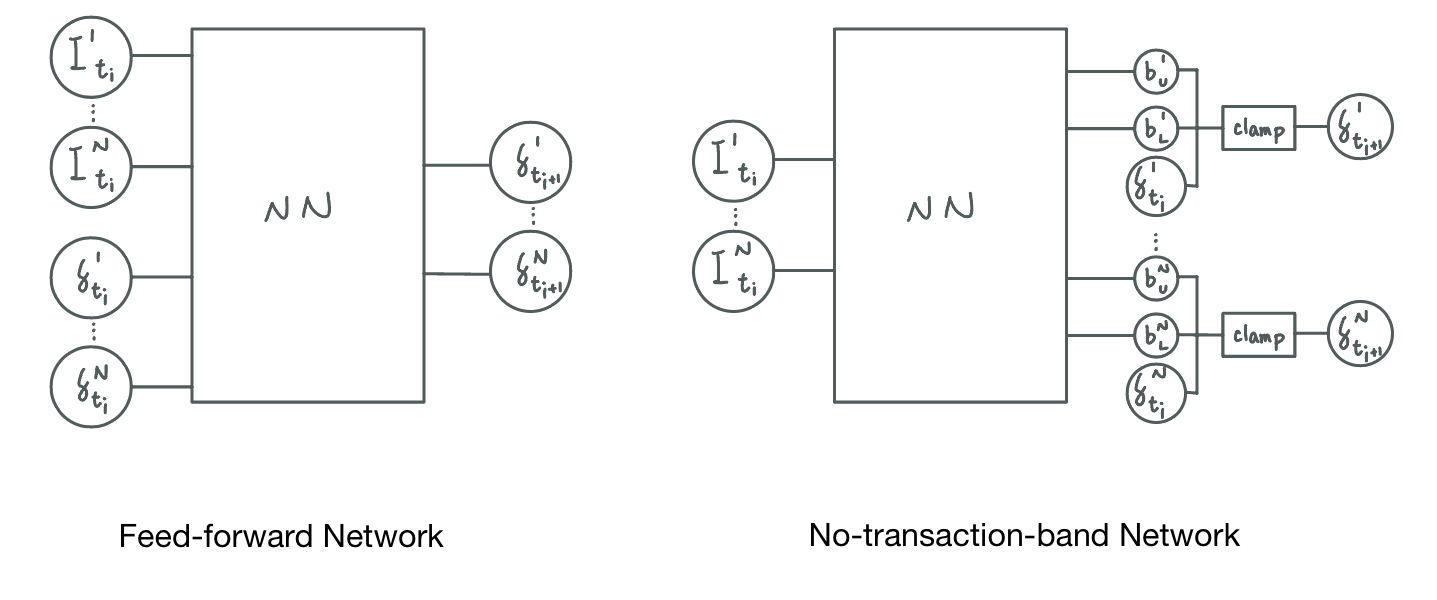

In [ ]:
class NoTransactionBandNet(torch.nn.Module):
    def __init__(self, in_features=3,  layer =4, node = 32):
        super().__init__()

        # A four-layer MLP with 32 hidden neurons in each layer
        self.mlp = MultiLayerPerceptron(in_features * HEDGE_NUMBER, 2 * HEDGE_NUMBER, layer, node)

    def forward(self, x, prev):
        # Black-Scholes' delta in the absence of transaction cost
        no_cost_delta = [1] * HEDGE_NUMBER

        hedge_list = [1] * HEDGE_NUMBER

        for i in range( HEDGE_NUMBER) :
            no_cost_delta[i] = european_option_delta(x[:, 0+i*3], x[:, 1+i*3], x[:, 2+i*3])

        # Compute no-transaction band using the multi-layer perceptron
        band_width = self.mlp(x)

        for i in range(HEDGE_NUMBER) :
            lower = no_cost_delta[i] - fn.leaky_relu(band_width[:, 0+i])
            upper = no_cost_delta[i] + fn.leaky_relu(band_width[:, 1+i])
            hedge_list[i] = clamp(prev[i], lower, upper)


        return torch.stack((hedge_list), dim = 0)

In [ ]:
class FeedForwardNet(torch.nn.Module):

    def __init__(self, in_features=3,  layer =4, node = 32):
        super().__init__()

        # A four-layer MLP with 32 hidden neurons in each layer
        self.mlp = MultiLayerPerceptron((in_features + 1) * HEDGE_NUMBER, HEDGE_NUMBER, layer, node)

    def forward(self, x, prev):
        # Black-Scholes' delta in the absence of transaction cost

        no_cost_delta = [1] * HEDGE_NUMBER
        hedge_list = [1] * HEDGE_NUMBER

        for i in range( HEDGE_NUMBER) :
            no_cost_delta[i] = european_option_delta(x[:, 0+i*3], x[:, 1+i*3], x[:, 2+i*3])

        # Multi-layer perceptron directly computes the hedge ratio at the next time step

        x = torch.cat((x, prev.reshape(-1, HEDGE_NUMBER)), 1)
        x = self.mlp(x)
        x = torch.tanh(x)

        for i in range(HEDGE_NUMBER):
            hedge_list[i] = no_cost_delta[i] + x[:,i]


        return torch.stack((hedge_list), dim = 0)

In [ ]:
torch.manual_seed(40)


### Compute profit and loss before training

In [ ]:
model_ffn = FeedForwardNet( layer = 6, node = 32).to(DEVICE)

pnl_ffn = compute_profit_and_loss(model_ffn, cost=1e-3, payoff = [european_option_payoff,european_option_payoff,european_option_payoff,european_option_payoff])


In [ ]:
model_ntb = NoTransactionBandNet(layer = 6, node = 32).to(DEVICE)

pnl_ntb = compute_profit_and_loss(model_ntb, cost=1e-3, payoff = [european_option_payoff,european_option_payoff,european_option_payoff,european_option_payoff])

#model_deep_ntb = NoTransactionBandNet(hedge_number = 3, layer = 8).to(DEVICE)

#pnl_deep_ntb = compute_profit_and_loss(model_deep_ntb, european_option_payoff, cost=1e-3)


In [ ]:
print("Feed-forward               mean : ",f"{np.mean(to_numpy(pnl_ffn)):.5f}", "  std : ", f"{np.std(to_numpy(pnl_ffn)):.5f}")
print("No-transaction band        mean : ",f"{np.mean(to_numpy(pnl_ntb)):.5f}", "  std : ", f"{np.std(to_numpy(pnl_ntb)):.5f}")

#print("Deeper No-transaction band mean : ",f"{np.mean(to_numpy(pnl_deep_ntb)):.5f}", "  std : ", f"{np.std(to_numpy(pnl_deep_ntb)):.5f}")


Feed-forward               mean :  -0.09713   std :  0.01576
No-transaction band        mean :  -0.09578   std :  0.00810


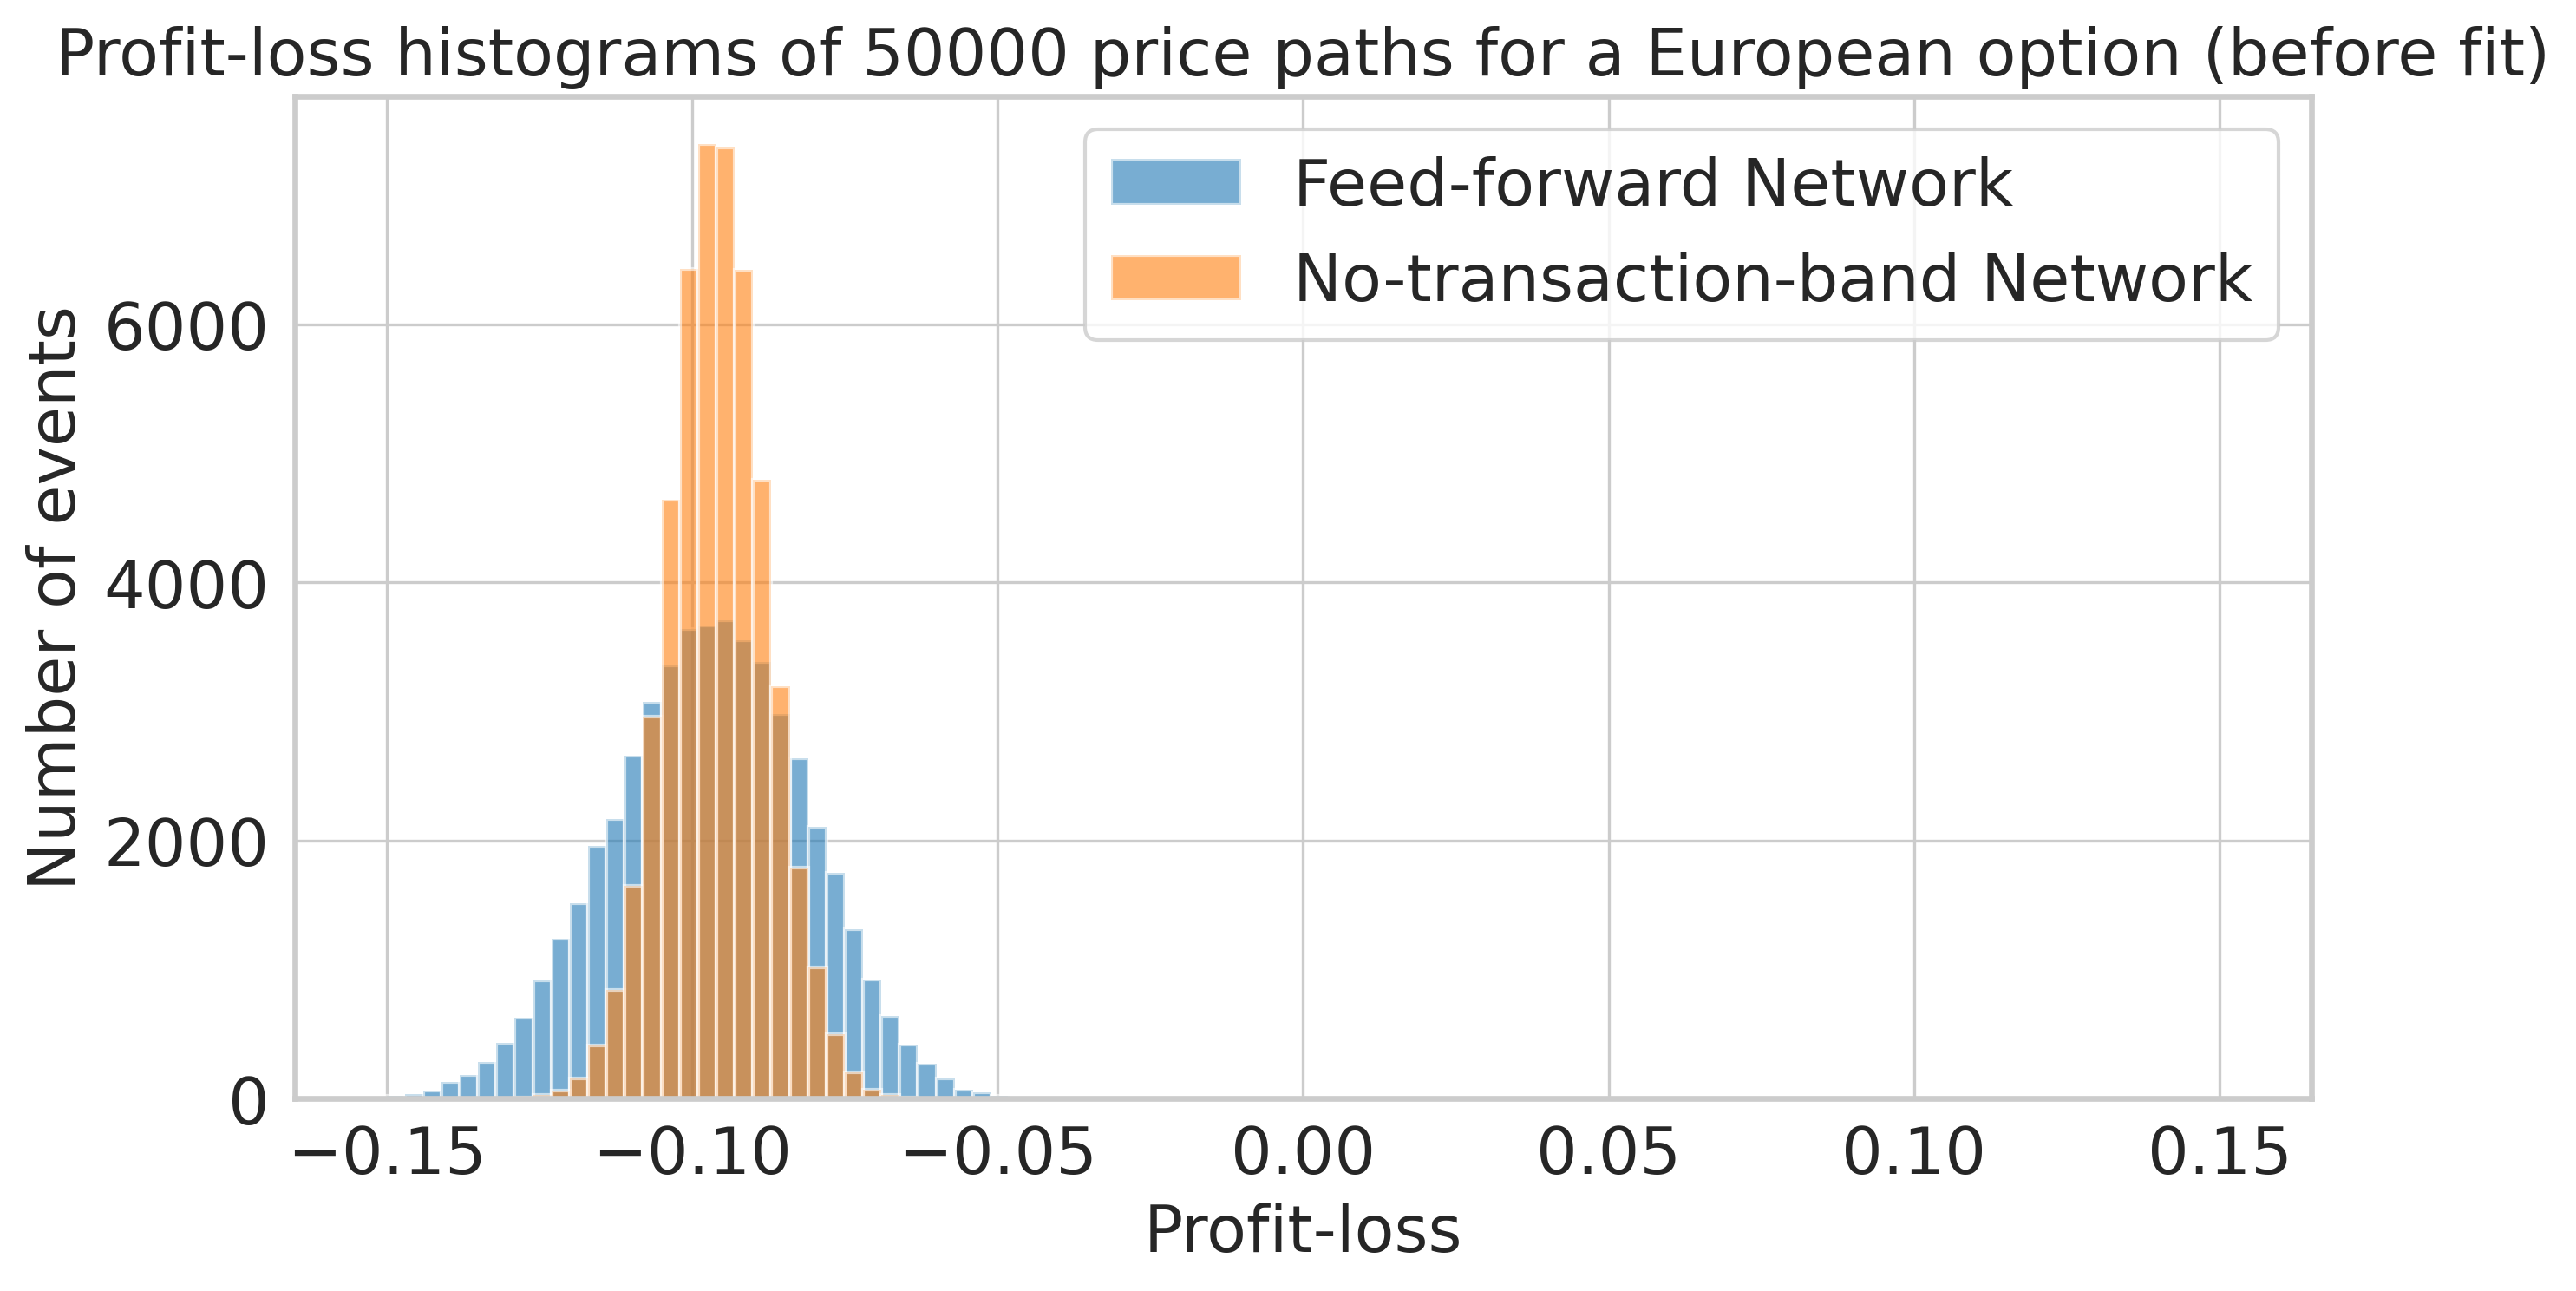

In [ ]:
plt.figure()

plt.hist(
    to_numpy(pnl_ffn),
    bins=100,
    range=(-0.15, 0.15),
    alpha=0.6,
    label="Feed-forward Network",
)
plt.hist(
    to_numpy(pnl_ntb),
    bins=100,
    range=(-0.15, 0.15),
    alpha=0.6,
    label="No-transaction-band Network",
)


plt.title(
    "Profit-loss histograms of 50000 price paths for a European option (before fit)"
)
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.legend()
plt.show()

The profit and loss distributions with hedging are shown in the histograms above.

These distributions are not optimal since `hedgin_model`s are not yet trained.

### Fit hedging models

We train hedging models so that they minimize the `entropic_loss`, or equivalently, maximize the expected utility.

In [ ]:
def fit(
    hedging_model: torch.nn.Module,
    cost: float,
    payoff = [...,european_option_payoff],
    n_epochs=N_EPOCHS,
) -> list:

    optim = Adam(hedging_model.parameters())

    loss_history = []
    progress = tqdm(range(n_epochs))

    for _ in progress:
        optim.zero_grad()
        pnl = compute_profit_and_loss(hedging_model,cost=cost, payoff = payoff )
        loss = entropic_loss(pnl)
        loss.backward()
        optim.step()

        progress.desc = f"Loss={loss:.5f}"
        loss_history.append(loss.item())

    return loss_history

In [ ]:

history_ffn = fit(model_ffn, cost=1e-3, payoff = [european_option_payoff,european_option_payoff,european_option_payoff,european_option_payoff])
history_ntb = fit(model_ntb, cost=1e-3, payoff = [european_option_payoff,european_option_payoff,european_option_payoff,european_option_payoff])



Loss=1.09436: 100%|██████████| 500/500 [01:43<00:00,  4.83it/s]


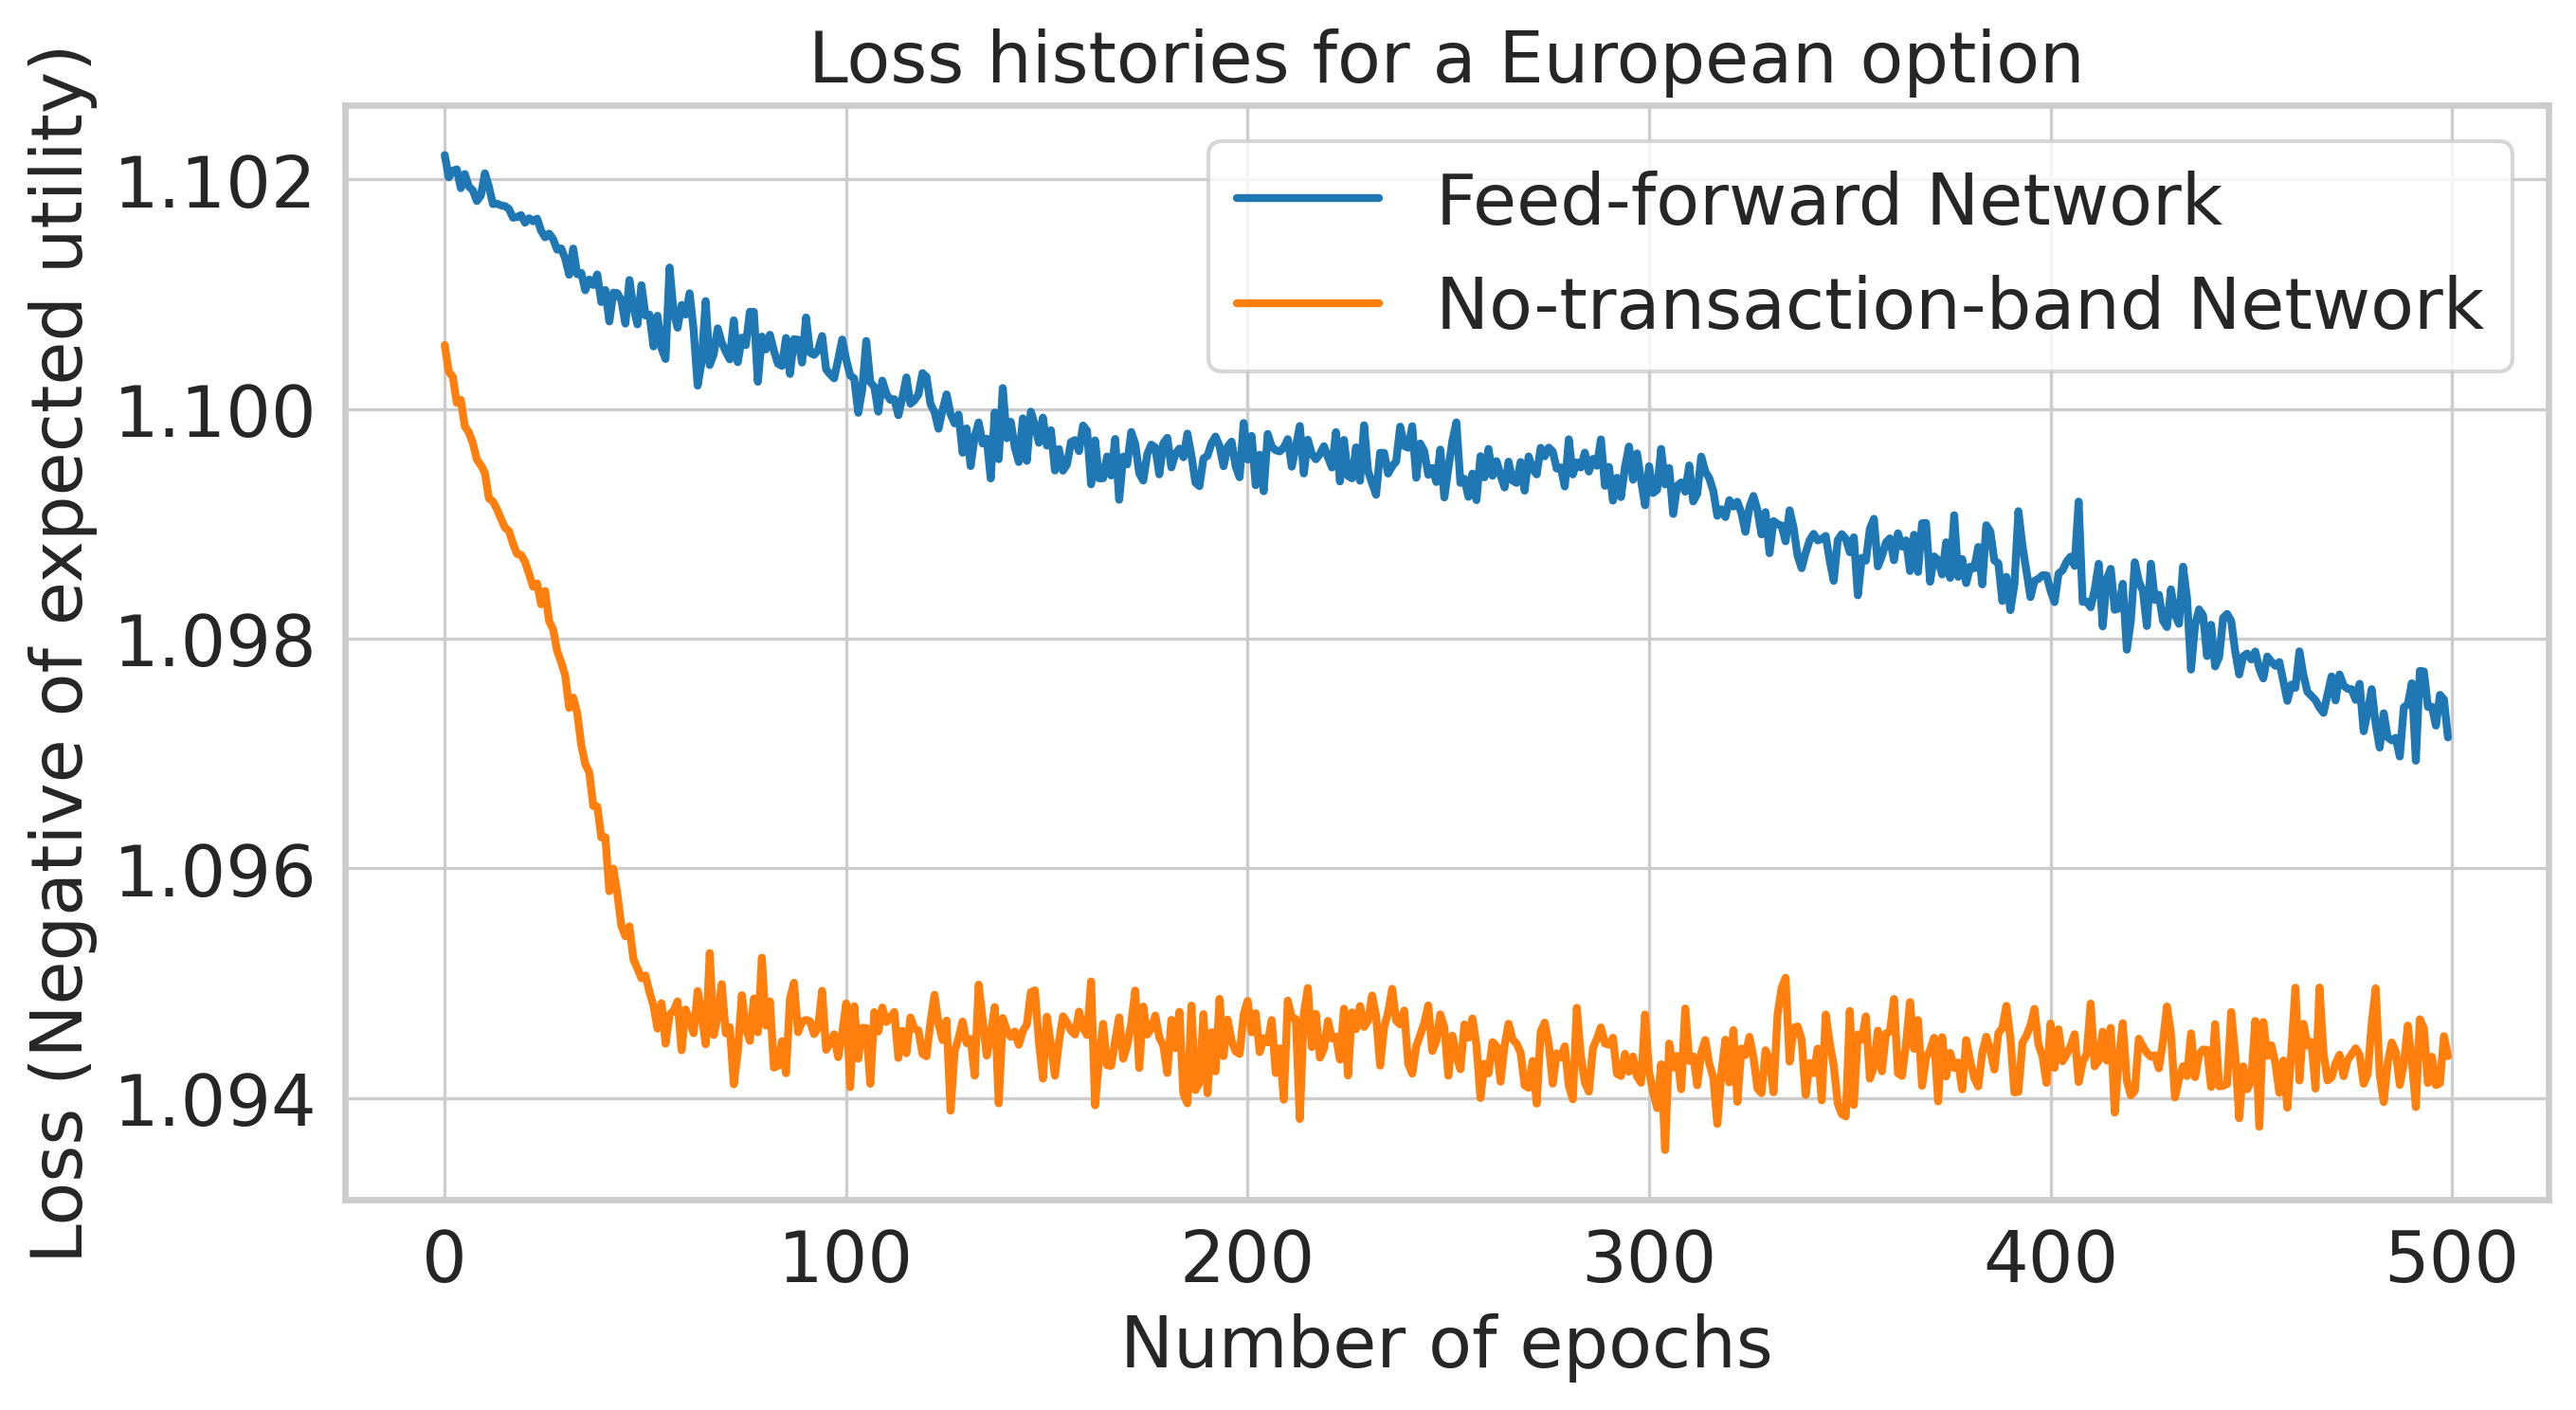

In [ ]:
plt.figure()
plt.plot(history_ffn, label="Feed-forward Network")
plt.plot(history_ntb, label="No-transaction-band Network")
#plt.plot(history_deep_ntb, label="No-transaction-band Deep Network")


plt.xlabel("Number of epochs")
plt.ylabel("Loss (Negative of expected utility)")
plt.title("Loss histories for a European option")
plt.legend(loc = 'upper right')
plt.show()



The learning histories above demonstrate that the no-transaction band network can be trained much quicker than the ordinary feed-forward network.

The fluctuations observed after around 100th epoch are mostly due to variances of Monte Carlo paths of the asset prices.

### Compute the profit-loss distributions with hedging

In [ ]:
pnl_ntb = compute_profit_and_loss(model_ntb, cost=1e-3, payoff = [european_option_payoff,european_option_payoff,european_option_payoff,european_option_payoff])

pnl_ffn = compute_profit_and_loss(model_ffn, cost=1e-3, payoff = [european_option_payoff,european_option_payoff,european_option_payoff,european_option_payoff])

#pnl_deep_ntb = compute_profit_and_loss(model_deep_ntb, european_option_payoff, cost=1e-3)


In [ ]:
print("No-transaction band        mean : ",f"{np.mean(to_numpy(pnl_ntb)):.5f}", "  std : ", f"{np.std(to_numpy(pnl_ntb)):.5f}")
print("Feed-forward               mean : ",f"{np.mean(to_numpy(pnl_ffn)):.5f}", "  std : ", f"{np.std(to_numpy(pnl_ffn)):.5f}")
#print("Deeper No-transaction band mean : ",f"{np.mean(to_numpy(pnl_deep_ntb)):.5f}", "  std : ", f"{np.std(to_numpy(pnl_deep_ntb)):.5f}")


No-transaction band        mean :  -0.08930   std :  0.05010
Feed-forward               mean :  -0.09182   std :  0.04427


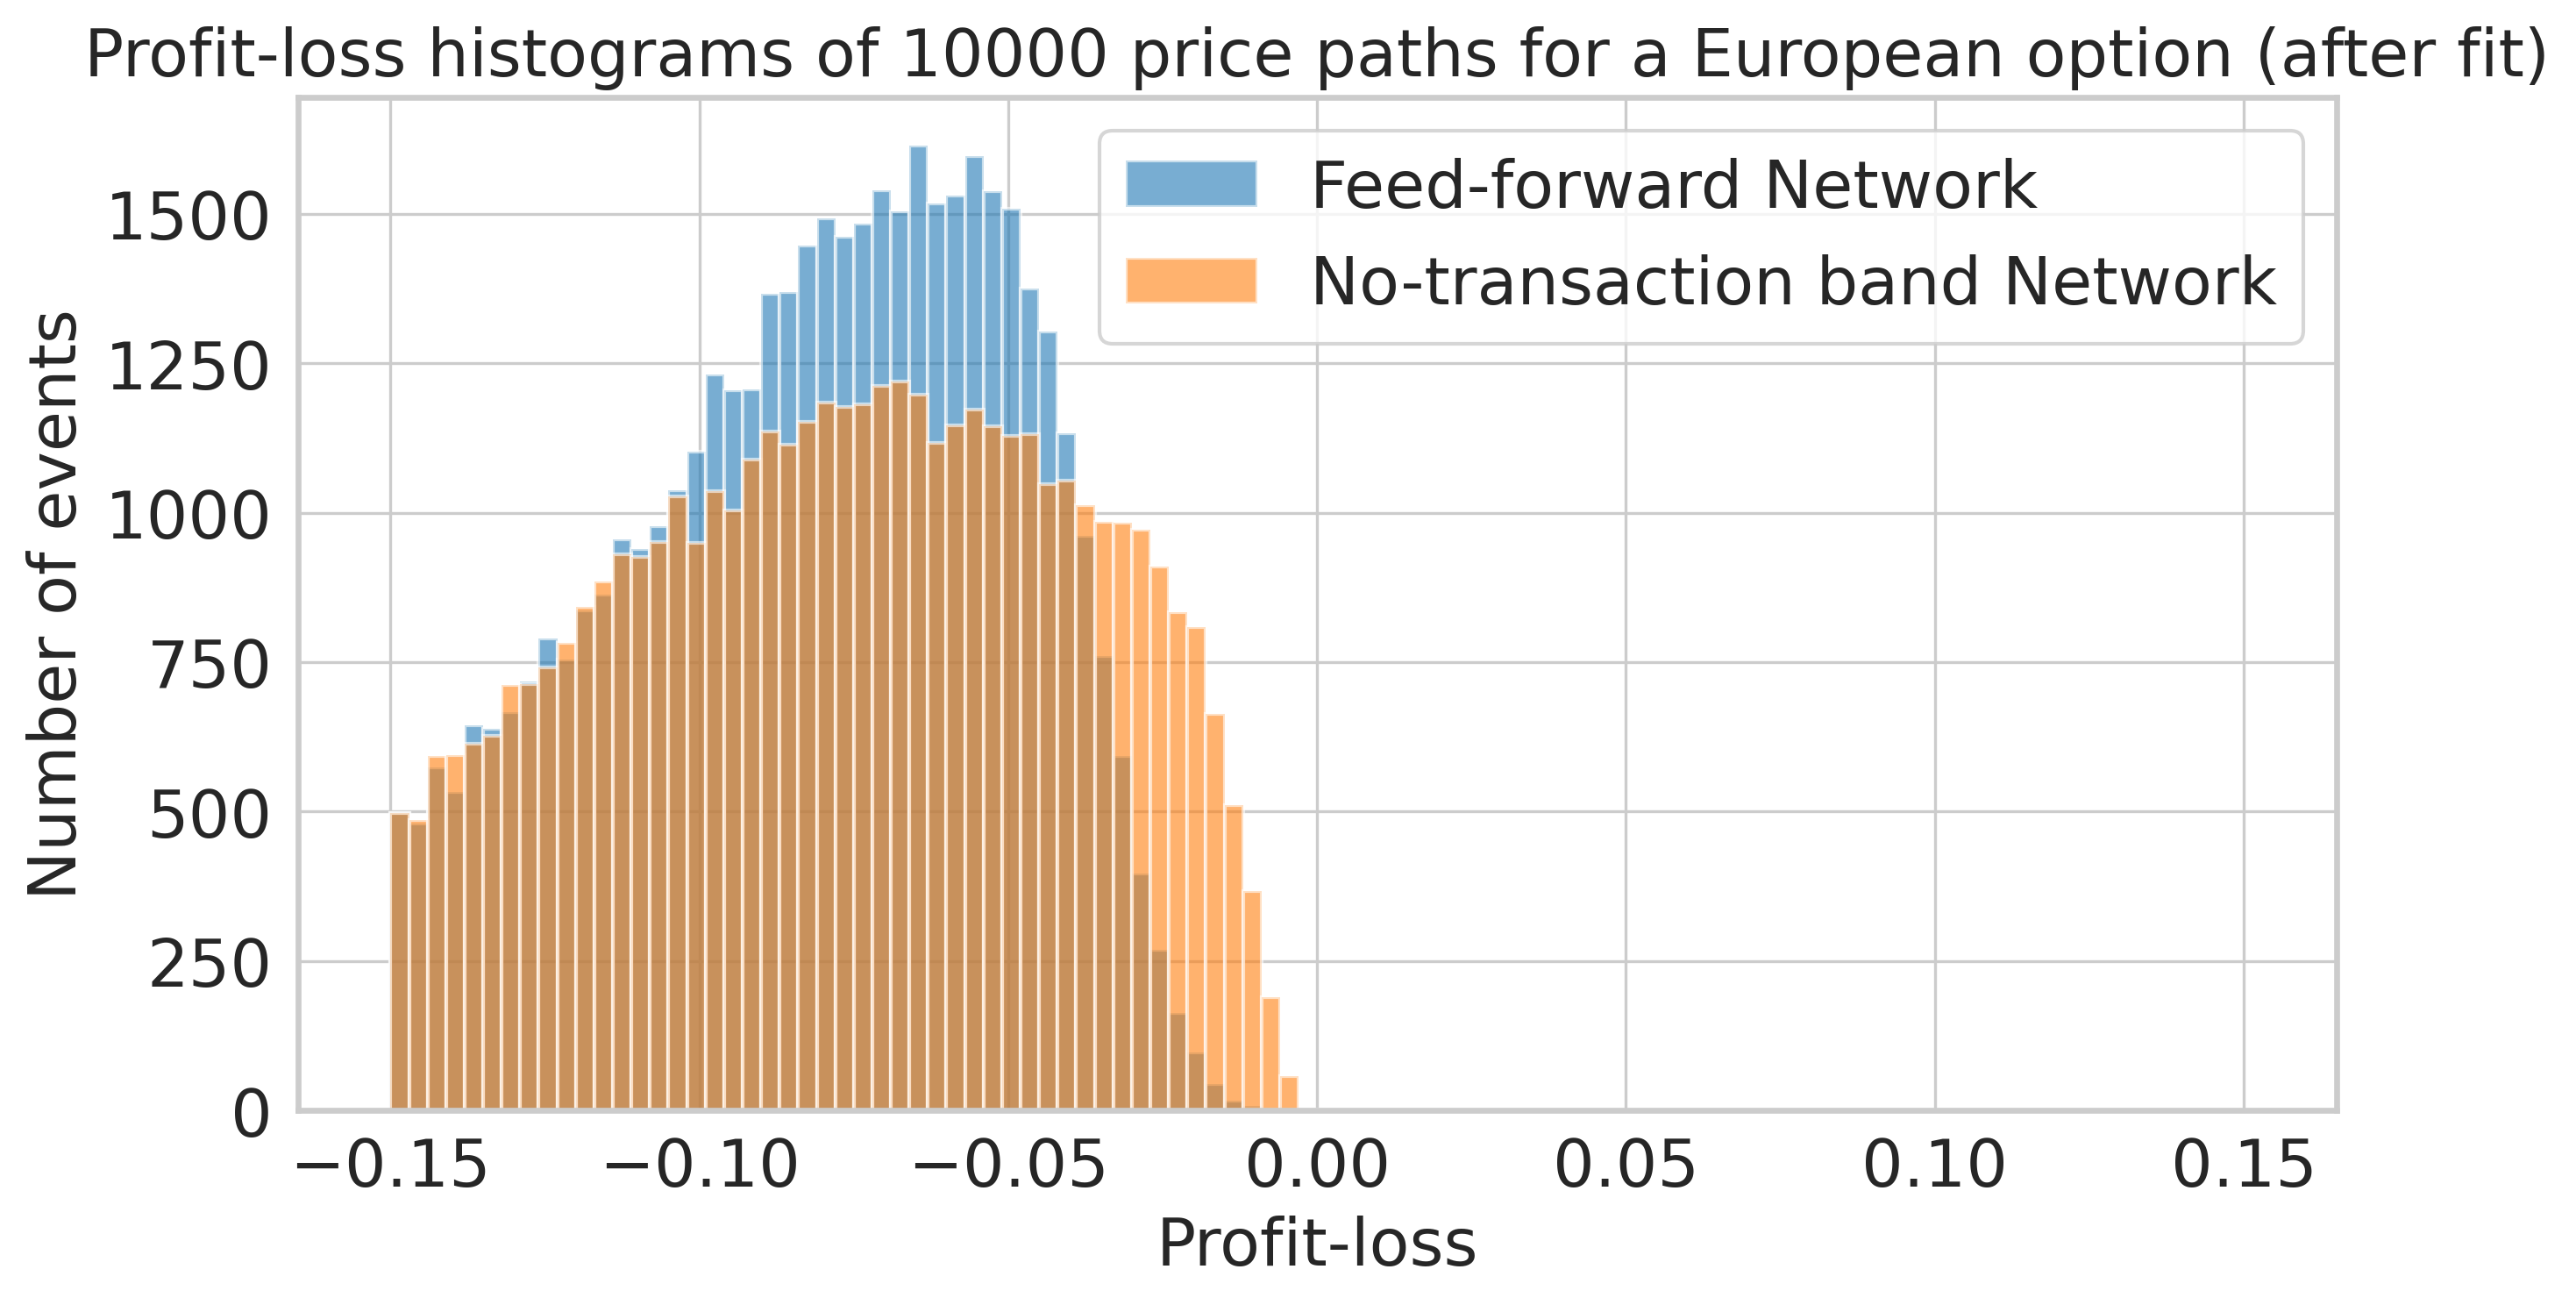

In [ ]:
plt.figure()

plt.hist(
    to_numpy(pnl_ffn),
    bins=100,
    range=(-0.15, 0.15),
    alpha=0.6,
    label="Feed-forward Network",
)
plt.hist(
     to_numpy(pnl_ntb),
     bins=100,
     range=(-0.15, 0.15),
     alpha=0.6,
     label="No-transaction band Network",
 )


plt.title(
    "Profit-loss histograms of 10000 price paths for a European option (after fit)"
)
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.legend()
plt.show()

The histograms of the profit and loss after hedging look like above.

The no-transaction band network saves on transaction cost while avoiding great losses.

### Evaluate the best premium of the derivative

Now, we are ready to define the premium of the derivative.

Premium of a derivative is defined as the guaranteed amount of cash which is as preferable as the profit-loss after hedging in terms of the exponential utility.

In [ ]:
def evaluate_premium(
    hedging_model: torch.nn.Module,
    cost: float,
    payoff = [...,european_option_payoff],
    n_times=20,
) -> float:
    """
    Evaluate the premium of the given derivative.

    Parameters
    ----------
    - hedging_model : torch.nn.Module
        Hedging model to fit.
    - payoff : callable[[torch.Tensor], torch.Tensor]
        Payoff function of the derivative to hedege.
    - cost : float, default 0.0
        Transaction cost of underlying asset.
    - n_times : int, default 20
        If `n_times > 1`, return ensemble mean of the results
        from multiple simulations.

    Returns
    -------
    premium : float
    """
    with torch.no_grad():
        p = lambda: -to_premium(
            compute_profit_and_loss(hedging_model, cost=cost, payoff = payoff )
        ).item()
        return float(np.mean([p() for _ in range(n_times)]))

In [ ]:
premium_ntb = evaluate_premium(model_ntb, cost=1e-3, payoff = [european_option_payoff,european_option_payoff,european_option_payoff,european_option_payoff])

premium_ffn = evaluate_premium(model_ffn, cost=1e-3, payoff = [european_option_payoff,european_option_payoff,european_option_payoff,european_option_payoff])


The no-transaction band network allows for a cheaper price.

In [ ]:
print("Premium of a European option evaluated by the no-transaction band network     :\t", f"{premium_ntb:.6f}")
print("Premium of a European option evaluated by the feed-forward band network       :\t", f"{premium_ffn:.6f}")


Premium of a European option evaluated by the no-transaction band network     :	 0.090111
Premium of a European option evaluated by the feed-forward band network       :	 0.092816


In [ ]:
premium_reduced = (premium_ffn - premium_ntb) / premium_ffn * 100
print("Reduced premium of a European option :\t", f"{premium_reduced:.4f} %")

Reduced premium of a European option :	 2.9146 %
